***Text Summerization : Classical and Transformer Based Appraches***

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load the data directories
train_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_train/cnn_train_data.csv')
test_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_test/cnn_test_data.csv')
val_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_validation/cnn_validation_data.csv')

#### **Exploratory Data Analysis**

In [ ]:
train_data.describe()
train_data.head(5)

,Unnamed: 0,article,highlights,id
0,0,By . Daily Mail Reporter . PUBLISHED: . 04:03 ...,Lackland Air Force Base instructor Christopher...,aaa6237fb3dabcc34f95ad010c15d90a55c769c4
1,1,"By . Martin Robinson . PUBLISHED: . 10:45 EST,...",Leanne Zaloumis was found by the music mogul s...,57fc39ad6aadaf215f7bbedf3f5947d93a3dec60
2,2,"By . Luke Salkeld . UPDATED: . 07:48 EST, 16 N...",One was posted from Paris - three days after G...,0fd3a209c873fb5229ea4d752f486645002c03f9
3,3,"By . Helen Collis . PUBLISHED: . 13:47 EST, 3 ...",Alex Shirra was unconscious for 12 days after ...,c53e85eca2140700b5c3a522ac34eddceeda73b4
4,4,"By . David Baker . PUBLISHED: . 13:54 EST, 2 A...",Firebombing comes after man stormed reception ...,4324f10606dca366e937dfcb1453c6a9d5364151


In [ ]:
test_data.describe()

,Unnamed: 0
count,11490.000000
mean,5744.500000
std,3317.021631
min,0.000000
25%,2872.250000
50%,5744.500000
75%,8616.750000
max,11489.000000


In [ ]:
val_data.describe()

,Unnamed: 0
count,13368.000000
mean,6683.500000
std,3859.153534
min,0.000000
25%,3341.750000
50%,6683.500000
75%,10025.250000
max,13367.000000


In [ ]:
# missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Unnamed: 0    0
article       0
highlights    0
id            0
dtype: int64


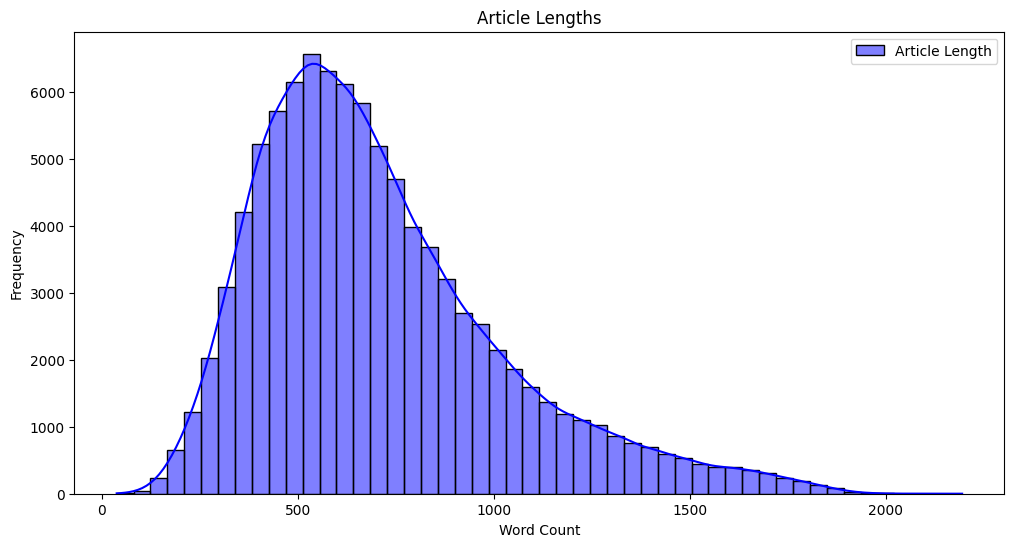

In [ ]:
# length of each article and highlights
train_data['article_length'] = train_data['article'].apply(lambda x: len(x.split()))
# Plot distribution of article length
plt.figure(figsize=(12,6))
sns.histplot(train_data['article_length'], bins=50, kde=True, color='blue', label='Article Length')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Article Lengths")
plt.show()

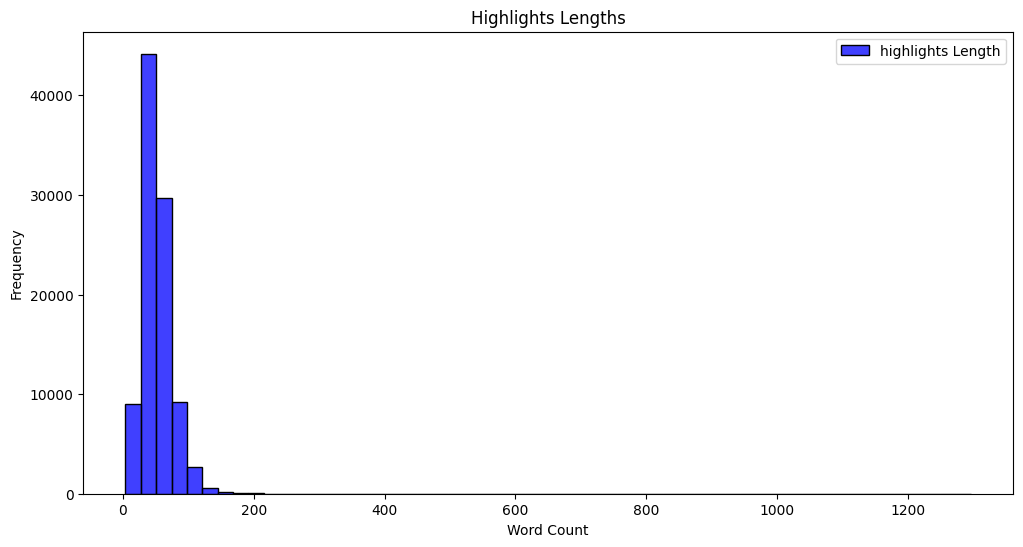

In [ ]:
train_data['highlights_length'] = train_data['highlights'].apply(lambda x: len(x.split()))

# Highlights length
plt.figure(figsize=(12,6))
sns.histplot(train_data['highlights_length'], bins=55, color='blue',  label='highlights Length')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Highlights Lengths")
max_word_count = train_data['highlights_length'].max()
plt.xticks(np.arange(0, max_word_count + 1, 200))
plt.show()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# def plot_wordcloud(text, title):
#     wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color="white").generate(" ".join(text))
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(title)
#     plt.show()

# Plot word clouds
# plot_wordcloud(train_data['article'], 'Word Cloud for Articles')
# plot_wordcloud(train_data['highlights'], 'Word Cloud for Summaries')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Data Preprocessing**

In [5]:
csv_path ='/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_test/cnn_test_data.csv'

# load dataset
def load_cnn_daily_mail_dataset(csv_path):
    # Load data from CSV
    df = pd.read_csv(csv_path)

    # random  20 rows
    sample_df = df.sample(n=20, random_state=42)

    # Convert sample to a list of dictionaries with 'article' and 'highlights'
    data = sample_df[['article', 'highlights']].to_dict(orient='records')

    return data

In [6]:
data_samples = load_cnn_daily_mail_dataset(csv_path)
data_samples[10]['article']
example_article = data_samples[10]["article"]
original_summary = data_samples[10]["highlights"]

print("Original Article:", example_article)
print("Original Summary:", original_summary)

Original Article: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. The bus came under armed attack as it drove to the airport following an away match at Caykur Rizespor in Turkey's Super Lig. Fener said on their official website the bus driver was wounded in the attack and taken to hospital and there was no mention of any injuries to anyone else. Marks can be seen on the windscreen of the Fenerbahce team bus after the attack . The window nearest the driver was smashed during the attack on Saturday night . The injured driver, with blood seeping from a head wound, seeks help  after the attack . A statement on the club's official website on Sunday said: 'We consider that as long as this attack is not solved in a way that satisfies Fenerbahce and public opinion, a suspension of the championship is inevitable. 'Blood ran and football was silenced. Finding and punishing the culprits is of vital importance for Fenerb

In [7]:
# Download NLTK stopwords
nltk.download("stopwords")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
# Text Preprocessing
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    # Removing stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [12]:
Inference_time={}

####  **Bag of Words**

In [13]:
# Bag of Words Summarization
def summarize_with_bow(article_text, num_sentences=2):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article_text)
    # Preprocess sentences
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using Bag of Words
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # similarity score
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary

# Generate summary for an example article

summary = summarize_with_bow(example_article)

# print("Original Article:", example_article)
print("Generated Summary:", summary)

Generated Summary: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. Marks can be seen on the windscreen of the Fenerbahce team bus after the attack .


In [14]:
def Calculate_Rouge_Bow(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        bow_summary = summarize_with_bow(row['article'])
        scores = scorer.score(original_summary, bow_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    BoW_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return BoW_avg_scores

In [15]:
start_time = time.time()
Bow_summary = summarize_with_bow(example_article)
end_time = time.time()
Inference_time['BoW'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")
avg_BoW_Rouge = Calculate_Rouge_Bow(val_data)

Time taken: 0.004126071929931641 seconds


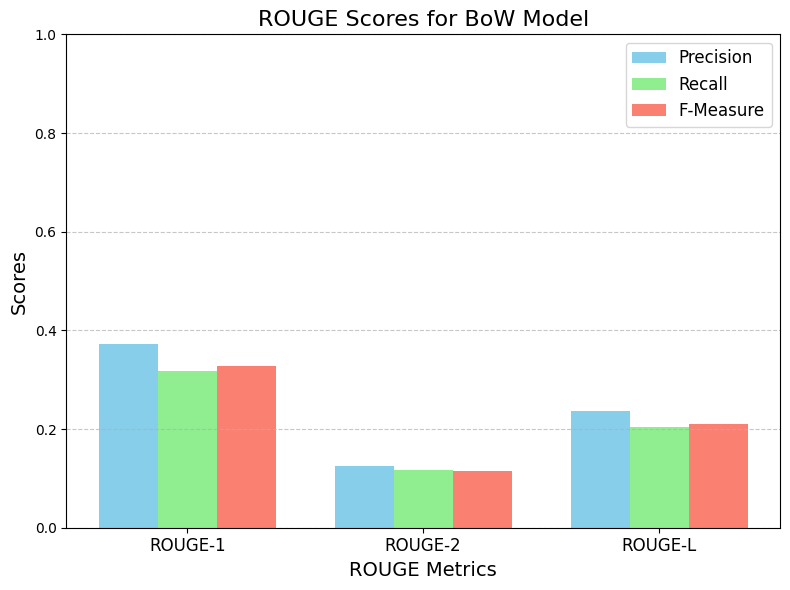

In [16]:
def plot_rouge_BoW(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BoW Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `avg_scores` is the output of `Calculate_Rouge_Bow`
plot_rouge_BoW(avg_BoW_Rouge)


#### **TF - IDF**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#  TF-IDF
def summarize_with_tfidf(article_text, num_sentences=2):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article_text)
    # Preprocess sentences
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using TF-IDF
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Rank sentences by similarity scores
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary

# Generate summary

summary = summarize_with_tfidf(example_article)
print("Generated Summary:", summary)

Generated Summary: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. The club posted several pictures of the bus on their website after the attack which showed a shattered side window and damage to the front windscreen.


In [18]:
def Calculate_Rouge_TF_IDF(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        TFIDF_summary = summarize_with_tfidf(row['article'])
        scores = scorer.score(original_summary, TFIDF_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    TFIDF_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return TFIDF_avg_scores

In [19]:
start_time = time.time()
TF_IDF_summary = summarize_with_tfidf(example_article)
end_time = time.time()
Inference_time['TF-IDF'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")
avg_TFIDF_Rouge = Calculate_Rouge_TF_IDF(val_data)

Time taken: 0.0042877197265625 seconds


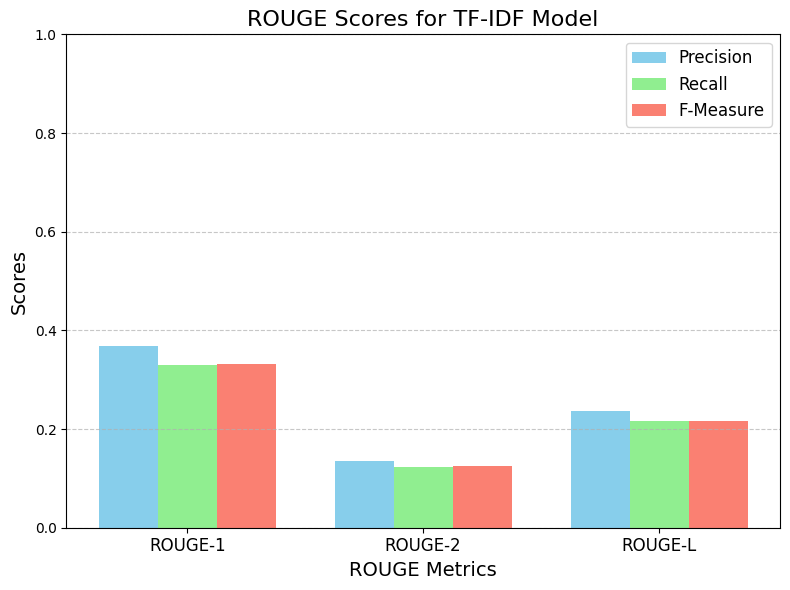

In [20]:
def plot_rouge_TFIDF(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for TF-IDF Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `avg_scores` is the output of `Calculate_Rouge_Bow`
plot_rouge_TFIDF(avg_TFIDF_Rouge)

#### **T5 (Text-to-Text Transfer Transformer)**

In [21]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np

In [22]:
cnn_dailymail = load_dataset("cnn_dailymail", "1.0.0")
sampled_dataset = cnn_dailymail["train"].select(range(30000))
cnn_dailymail = sampled_dataset.train_test_split(test_size=0.2)
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [23]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True,padding=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [24]:
tokenized_cnn_dailymail = cnn_dailymail.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)
rouge = evaluate.load("rouge")
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    print("Sample Predictions:", decoded_preds[:3])  # Log some predictions
    return {k: round(v, 4) for k, v in result.items()}

In [26]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,

)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_cnn_dailymail["train"],
    eval_dataset=tokenized_cnn_dailymail["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-369e122fd70e>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.109700,1.019239,0.239200,0.099300,0.193000,0.193100,19.953300
2,1.090800,1.012629,0.240600,0.100400,0.194600,0.194700,19.990000
3,1.085200,1.011719,0.240200,0.100200,0.194600,0.194600,19.996700


Sample Predictions: ['The kids and I made history this summer. They decided to go to Savannah, Georgia, and', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. Winds', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']
Sample Predictions: ['Savannah, 11, and Camron, 12, decided on itineraries for their summer trips.', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. NEW:', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']
Sample Predictions: ['Savannah, 11, and Camron, 12, decided on itineraries for their summer trips.', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. NEW:', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']


TrainOutput(global_step=9000, training_loss=1.1392581990559896, metrics={'train_runtime': 4221.3928, 'train_samples_per_second': 17.056, 'train_steps_per_second': 2.132, 'total_flos': 1.938037711228109e+16, 'train_loss': 1.1392581990559896, 'epoch': 3.0})

In [27]:
model_name = "/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models/checkpoint-9000"  # Replace with your checkpoint's model path
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [28]:
def summerize_with_T5(article_text):
    inputs = tokenizer(article_text, return_tensors="pt", max_length=1024, truncation=True)
    start_time = time.time()
    outputs = model.generate(
          **inputs,
          max_length=1024,
          early_stopping=True,
          temperature=0.8,
          top_k=70,
          top_p=0.8,
          num_beams=4,
      )
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

In [29]:
def Calculate_Rouge_T5(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        T5_summary = summerize_with_T5(row['article'])
        scores = scorer.score(original_summary, T5_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    T5_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return T5_avg_scores

In [30]:
start_time = time.time()
T5_Summary = summerize_with_T5(example_article)
end_time = time.time()
Inference_time['T5'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")
avg_T5_rouge = Calculate_Rouge_T5(val_data)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `70` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Time taken: 2.2190165519714355 seconds


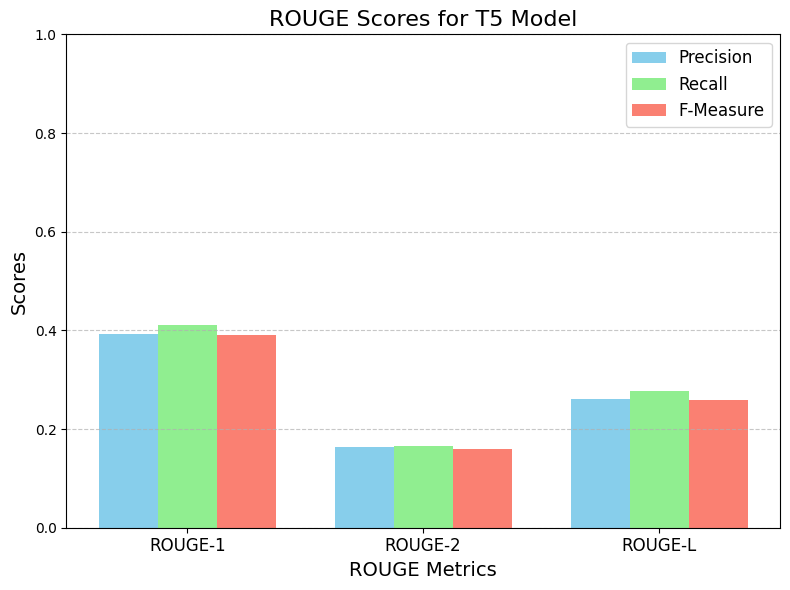

In [31]:
def plot_rouge_T5(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for T5 Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `avg_scores` is the output of `Calculate_Rouge_Bow`
plot_rouge_T5(avg_T5_rouge)


#### **BERT - Bidirectional Encoder Representations From Transformers**

In [32]:
%%capture
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
model = AutoModelForSeq2SeqLM.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")

Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> is overwritten by shared decoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "add_cross_attention"

In [33]:
from transformers import EncoderDecoderModel
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [34]:
def summerize_with_BERT(article_text):
    # Tokenize the input article
    inputs = tokenizer(article_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    device = next(model.parameters()).device  # Get model's device
    inputs = inputs.to(device)

    # Explicitly set the decoder_start_token_id if it's not already defined
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = tokenizer.cls_token_id  # or tokenizer.bos_token_id

    # start_time = time.time()
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,          # Max length of the generated summary
        num_beams=4,             # Beam search for quality improvement
        length_penalty=2.0,      # Encourage shorter summaries
        no_repeat_ngram_size=3,  # Avoid repetition
        early_stopping=True,
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [35]:
def Calculate_Rouge_BERT(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        BERT_summary = summerize_with_BERT(row['article'])
        scores = scorer.score(original_summary, BERT_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    BERT_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return BERT_avg_scores

In [36]:
start_time = time.time()
BERT_Summary =  summerize_with_BERT(example_article)
end_time = time.time()
Inference_time['BERT'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")
avg_BERT_rouge = Calculate_Rouge_BERT(val_data)

Time taken: 3.36370849609375 seconds


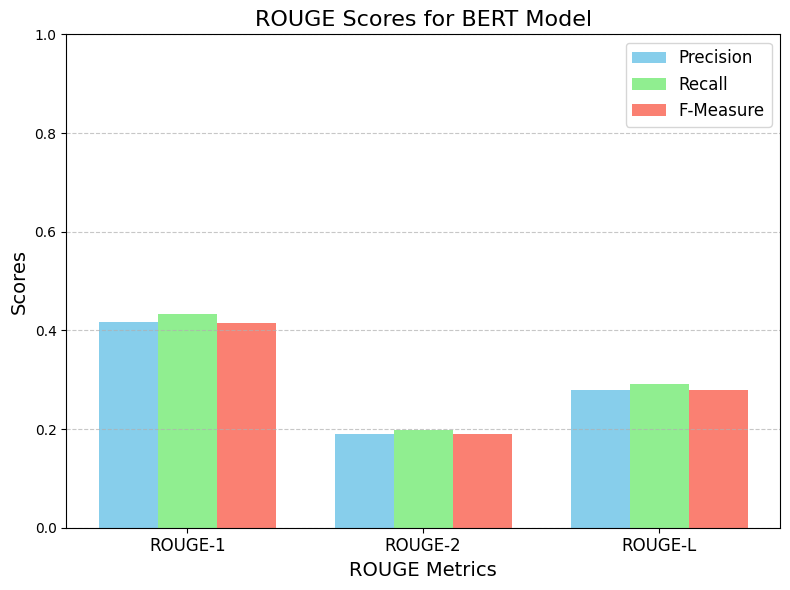

In [37]:
def plot_rouge_BERT(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BERT Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `avg_scores` is the output of `Calculate_Rouge_Bow`
plot_rouge_BERT(avg_BERT_rouge)

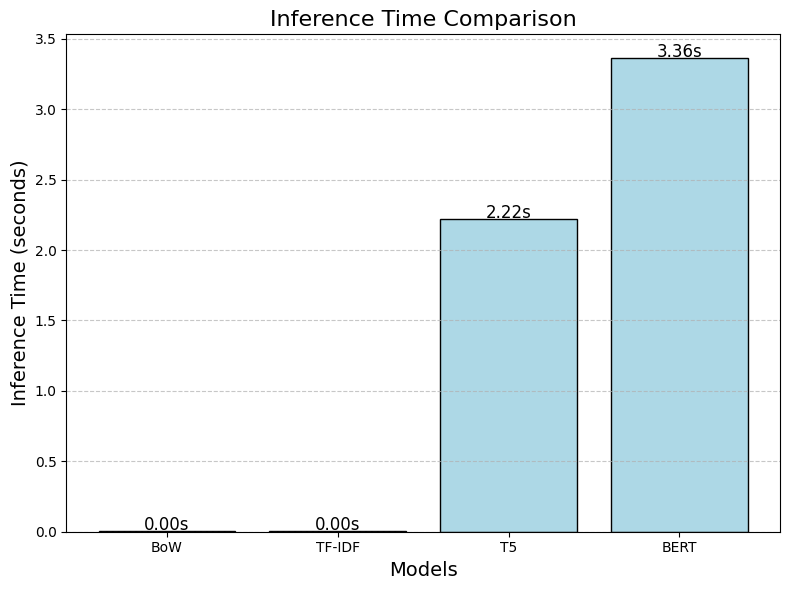

In [38]:
def plot_inference_times_from_dict(inference_times_dict):

    # Extract the model names (keys) and their corresponding inference times (values)
    models = list(inference_times_dict.keys())
    inference_times = list(inference_times_dict.values())

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(models, inference_times, color='lightblue', edgecolor='black')

    # Add titles and labels
    plt.title("Inference Time Comparison", fontsize=16)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Inference Time (seconds)", fontsize=14)

    # Annotate the bars with the actual inference times
    for i, time in enumerate(inference_times):
        plt.text(i, time + 0.01, f"{time:.2f}s", ha='center', fontsize=12)

    # Customize the grid and layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_inference_times_from_dict(Inference_time)

[0.3281739983034096, 0.33278928044454587, 0.38991900301098215, 0.41492694972382355]


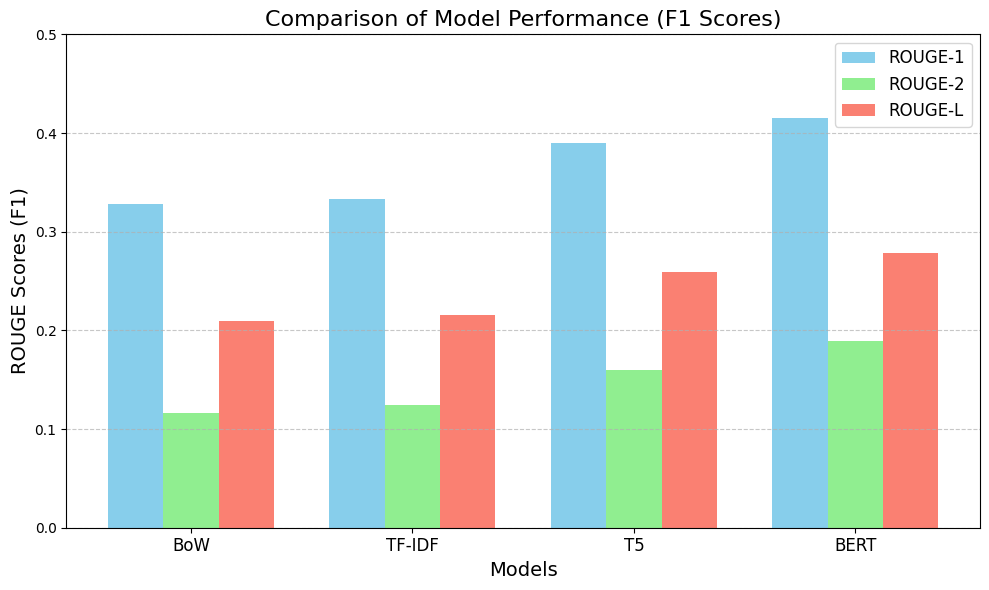

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['BoW', 'TF-IDF', 'T5', 'BERT']
rouge1_f1 = [avg_BoW_Rouge['ROUGE-1']['fmeasure'], avg_TFIDF_Rouge['ROUGE-1']['fmeasure'], avg_T5_rouge['ROUGE-1']['fmeasure'], avg_BERT_rouge['ROUGE-1']['fmeasure']]
rouge2_f1 = [avg_BoW_Rouge['ROUGE-2']['fmeasure'], avg_TFIDF_Rouge['ROUGE-2']['fmeasure'], avg_T5_rouge['ROUGE-2']['fmeasure'], avg_BERT_rouge['ROUGE-2']['fmeasure']]
rougeL_f1 = [avg_BoW_Rouge['ROUGE-L']['fmeasure'], avg_TFIDF_Rouge['ROUGE-L']['fmeasure'], avg_T5_rouge['ROUGE-L']['fmeasure'], avg_BERT_rouge['ROUGE-L']['fmeasure']]
print(rouge1_f1)

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, rouge1_f1, width, label='ROUGE-1', color='skyblue')
bar2 = ax.bar(x, rouge2_f1, width, label='ROUGE-2', color='lightgreen')
bar3 = ax.bar(x + width, rougeL_f1, width, label='ROUGE-L', color='salmon')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('ROUGE Scores (F1)', fontsize=14)
ax.set_title('Comparison of Model Performance (F1 Scores)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

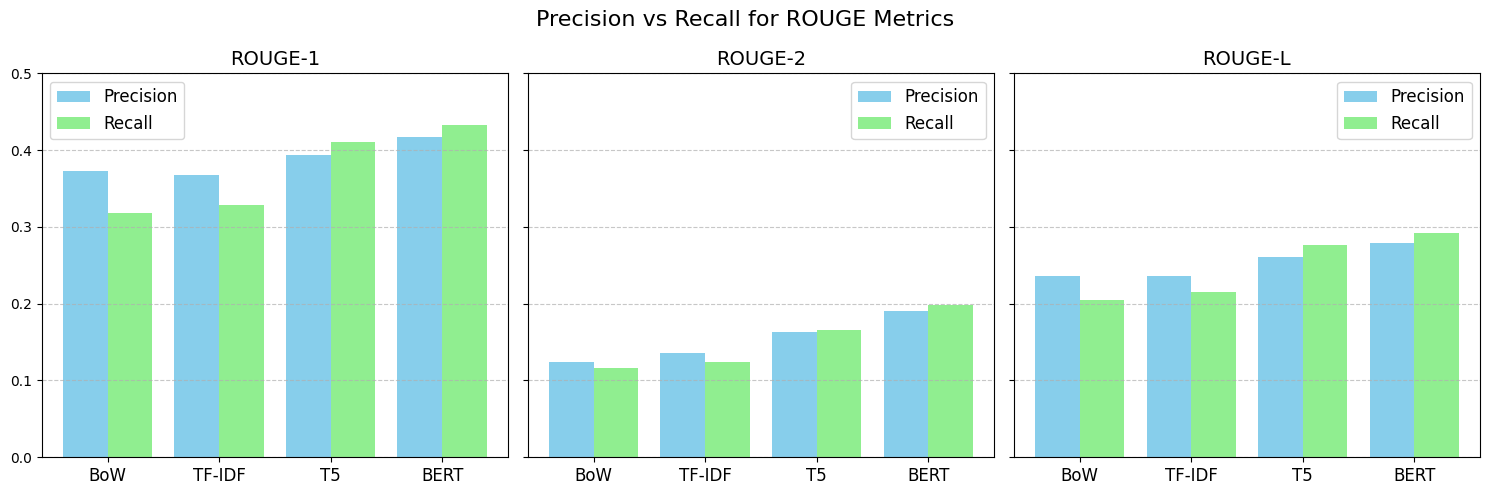

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['BoW', 'TF-IDF', 'T5', 'BERT']
precision = {
    'ROUGE-1': [avg_BoW_Rouge['ROUGE-1']['precision'], avg_TFIDF_Rouge['ROUGE-1']['precision'], avg_T5_rouge['ROUGE-1']['precision'], avg_BERT_rouge['ROUGE-1']['precision']],
    'ROUGE-2': [avg_BoW_Rouge['ROUGE-2']['precision'], avg_TFIDF_Rouge['ROUGE-2']['precision'], avg_T5_rouge['ROUGE-2']['precision'], avg_BERT_rouge['ROUGE-2']['precision']],
    'ROUGE-L': [avg_BoW_Rouge['ROUGE-L']['precision'], avg_TFIDF_Rouge['ROUGE-L']['precision'], avg_T5_rouge['ROUGE-L']['precision'], avg_BERT_rouge['ROUGE-L']['precision']]
}
recall = {
    'ROUGE-1': [avg_BoW_Rouge['ROUGE-1']['recall'], avg_TFIDF_Rouge['ROUGE-1']['recall'], avg_T5_rouge['ROUGE-1']['recall'], avg_BERT_rouge['ROUGE-1']['recall']],
    'ROUGE-2': [avg_BoW_Rouge['ROUGE-2']['recall'], avg_TFIDF_Rouge['ROUGE-2']['recall'], avg_T5_rouge['ROUGE-2']['recall'], avg_BERT_rouge['ROUGE-2']['recall']],
    'ROUGE-L': [avg_BoW_Rouge['ROUGE-L']['recall'], avg_TFIDF_Rouge['ROUGE-L']['recall'], avg_T5_rouge['ROUGE-L']['recall'], avg_BERT_rouge['ROUGE-L']['recall']]
}

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    x = np.arange(len(models))
    ax.bar(x - 0.2, precision[metric], width=0.4, label='Precision', color='skyblue')
    ax.bar(x + 0.2, recall[metric], width=0.4, label='Recall', color='lightgreen')
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylim(0, 0.5)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('Precision vs Recall for ROUGE Metrics', fontsize=16)
plt.tight_layout()
plt.show()